# Model Training notebook

Contains the whole pipeline to train the models.  
How to use:   

Run the first cells to import all needed models and functions  
Then run the cell that loads the weights, if none are present it will create a new model  
Run the training cell and adjust N and iterations accordingly. Using a higher N will use more RAM, so you can lower N and augment iterations.  
Finally if the results are are good, you can save the model weigths. Only do it if the results are nice, because it overwrites the old weigths. 
The last cell vizualizes 3 different reference images with very different D values. 

In [91]:
# Hyperparameters for simulation
nparticles = 1000   # Number of particles
nframes = 16    # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
DGen = 20000        # Diffusion coefficient in nm^2 per s (=0.000001 (um^2)/s)
num_steps = nframes*nposframe
# Hyperparameters for image generation
npixel = 64 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 100 
gaussian_noise = 10
background = 100 # base background value
normalizeValue = 1000 # value by which all samples will be normalized ! Needs to be fixed and the same for all images !
n_val_im = 50


In [101]:
%reload_ext autoreload
%autoreload 2
from helpers import *
from modelsUtils import *
from simpleCNNModel import *
from ResNetModel2D import *
from ResNetModel3D import *
from paperCNN import *
from paperCNNNoPooling import *
import os.path

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [93]:
# Models used in a dictionnary comprehension. 
# To add  anew model, simply add it to the list with the wanted train fct

lr = 0.000001
models_params = {
    "simpleCNN": {"class": SimpleCNN, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "resNet2D": {"class": ResNet2D, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "resNet3D": {"class": ResNet3D, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "paperCNNAdam": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "paperCNNSGD": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "sgd", "lr" :lr},
    "paperCNNNoPool": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" :lr}
    
}

In [94]:
for name, params in models_params.items():
    class_ = params["class"]
    # Load the model weights
    loaded_model = class_().to(device)
    filename = "w_" + name + ".pth"
    if os.path.exists(filename):
        loaded_model = load_model_weights(loaded_model, filename)
        print(name, "Loaded existing weights")
    else:
        print(name, "Did not find weights, loaded a new model")
        
    params["loaded_model"] = loaded_model  # Update the dictionary with the loaded model
    
    if(isinstance(params["optimizer"],str)):
        if params["optimizer"] == "adam":
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])
        elif params["optimizer"] == "sgd":
            params["optimizer"] = optim.SGD(loaded_model.parameters(), lr=params["lr"], momentum=0.9)
        else: 
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])

Model weights loaded from w_simpleCNN.pth
simpleCNN Loaded existing weights
Model weights loaded from w_resNet2D.pth
resNet2D Loaded existing weights
Model weights loaded from w_resNet3D.pth
resNet3D Loaded existing weights
Model weights loaded from w_paperCNNAdam.pth
paperCNNAdam Loaded existing weights
Model weights loaded from w_paperCNNSGD.pth
paperCNNSGD Loaded existing weights
Model weights loaded from w_paperCNNNoPool.pth
paperCNNNoPool Loaded existing weights


In [58]:
# run this cell to reset loss histories
totalEpochs = 0
tr_loss_histories = {name: [] for name in models_params.keys()}
val_loss_histories = {}

for name, params in models_params.items():

    filename = "l_" + name + ".npy"
    if os.path.exists(filename):
        val_loss_histories[name] = np.load(filename)
        print(name, "Loaded existing losses")
        totalEpochs = len(val_loss_histories[name])
    else:
        print(name, "Did not find losses, loaded an empty array")
        val_loss_histories[name] = np.array([])

ds = "allDs.npy"
if os.path.exists(ds):
    allGeneratedDs = np.load(ds)
else:
    allGeneratedDs = np.array([])   



simpleCNN Did not find losses, loaded an empty array
resNet2D Did not find losses, loaded an empty array
resNet3D Did not find losses, loaded an empty array
paperCNNAdam Did not find losses, loaded an empty array
paperCNNSGD Did not find losses, loaded an empty array
paperCNNNoPool Did not find losses, loaded an empty array


In [50]:
# load validation images
val_trajs = np.load('validation_trajectories.npy')
val_images, valDs = generateImagesAndEstimateDFromTrajs(val_trajs,n_val_im, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
valDs = torch.tensor(valDs/1000, dtype=torch.float32, device=device)

In [95]:
epochs = 250
N = 256 # Number of samples per iteration
verbose = False # print in console
for i in range(epochs):

    print(f"Generating images for iteration: {i}")

    images, estimatedDs =  generateImagesAndEstimateDMAXD(N, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
    
    # Divide the estimateDs by 10000 to get values in the range 0.5->70, then add them to the list of all Ds
    estimatedDs = estimatedDs / 1000
    allGeneratedDs = np.append(allGeneratedDs,estimatedDs)
    

    # Add channel dimension to images: (N, 16, 64, 64) -> (N, 16, 1, 64, 64)
    images = torch.tensor(images, dtype=torch.float32).unsqueeze(2)
    estimatedDs = torch.tensor(estimatedDs, dtype=torch.float32)


    for name, params in models_params.items():
        model = params["loaded_model"]
        train_fct = params["train_fct"]
        criterion = params["criterion"]
        optimizer = params["optimizer"]
        if(verbose):
            print("Training model:" , name)
        trained_model, tr_loss_history = train_fct(model, images, estimatedDs, device, criterion, optimizer, epochs=1, batch_size=16)
        params["loaded_model"] = trained_model

        # Compute validation loss on fixed set of images
        model_preds = predict_diffusion_coefficients(trained_model, val_images ,device)
        loss = criterion(model_preds, valDs)
        val_loss_histories[name] = np.append(val_loss_histories[name],loss.item())



        # Store the single training epoch loss
        if isinstance(tr_loss_history, list) and len(tr_loss_history) > 0:
            tr_loss_histories[name].append(tr_loss_history[-1])  # Append last loss in the history
        elif isinstance(tr_loss_history, (float, int)):  # If it's a single loss value
            tr_loss_histories[name].append(tr_loss_history)
        else:
            print(f"Unexpected loss format for model {name}: {tr_loss_history}")

# add up epochs for later use 
totalEpochs = totalEpochs + epochs



Generating images for iteration: 0


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 131.50it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.99it/s]


Generating images for iteration: 1


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 130.56it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.95it/s]


Generating images for iteration: 2


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.53it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.86it/s]


Generating images for iteration: 3


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.69it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.90it/s]


Generating images for iteration: 4


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.92it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:26<00:00,  9.84it/s]


Generating images for iteration: 5


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 121.13it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.69it/s]


Generating images for iteration: 6


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.83it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.78it/s]


Generating images for iteration: 7


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.06it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.65it/s]


Generating images for iteration: 8


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.06it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.81it/s]


Generating images for iteration: 9


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.11it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.73it/s]


Generating images for iteration: 10


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.24it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.76it/s]


Generating images for iteration: 11


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 123.06it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 12


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.59it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.77it/s]


Generating images for iteration: 13


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.37it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 14


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.67it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 15


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.81it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.80it/s]


Generating images for iteration: 16


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.99it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.86it/s]


Generating images for iteration: 17


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.61it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 18


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.65it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.76it/s]


Generating images for iteration: 19


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.50it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.77it/s]


Generating images for iteration: 20


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 120.53it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.60it/s]


Generating images for iteration: 21


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.13it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.56it/s]


Generating images for iteration: 22


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.27it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.61it/s]


Generating images for iteration: 23


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.19it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.76it/s]


Generating images for iteration: 24


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.27it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.78it/s]


Generating images for iteration: 25


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.10it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 26


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.21it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.62it/s]


Generating images for iteration: 27


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.72it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.73it/s]


Generating images for iteration: 28


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.87it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.86it/s]


Generating images for iteration: 29


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.11it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 30


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.30it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.59it/s]


Generating images for iteration: 31


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.10it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.69it/s]


Generating images for iteration: 32


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.65it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.72it/s]


Generating images for iteration: 33


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.47it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.77it/s]


Generating images for iteration: 34


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.37it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.83it/s]


Generating images for iteration: 35


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.93it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.76it/s]


Generating images for iteration: 36


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.85it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.67it/s]


Generating images for iteration: 37


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.63it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Generating images for iteration: 38


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.90it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.89it/s]


Generating images for iteration: 39


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.98it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 40


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.73it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.64it/s]


Generating images for iteration: 41


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.90it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.78it/s]


Generating images for iteration: 42


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.57it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.57it/s]


Generating images for iteration: 43


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.99it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.80it/s]


Generating images for iteration: 44


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.78it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.91it/s]


Generating images for iteration: 45


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.42it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.92it/s]


Generating images for iteration: 46


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.18it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.85it/s]


Generating images for iteration: 47


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.53it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.58it/s]


Generating images for iteration: 48


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.19it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Generating images for iteration: 49


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.20it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.89it/s]


Generating images for iteration: 50


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.83it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.75it/s]


Generating images for iteration: 51


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.02it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.90it/s]


Generating images for iteration: 52


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.75it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.69it/s]


Generating images for iteration: 53


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.83it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.87it/s]


Generating images for iteration: 54


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.01it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 55


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.51it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.72it/s]


Generating images for iteration: 56


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.18it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.72it/s]


Generating images for iteration: 57


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.62it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.71it/s]


Generating images for iteration: 58


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.97it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.73it/s]


Generating images for iteration: 59


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.55it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.58it/s]


Generating images for iteration: 60


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.37it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.88it/s]


Generating images for iteration: 61


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.55it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.68it/s]


Generating images for iteration: 62


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.23it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.66it/s]


Generating images for iteration: 63


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.24it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.57it/s]


Generating images for iteration: 64


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.37it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.60it/s]


Generating images for iteration: 65


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.30it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.72it/s]


Generating images for iteration: 66


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.99it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.85it/s]


Generating images for iteration: 67


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.68it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.96it/s]


Generating images for iteration: 68


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.45it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.96it/s]


Generating images for iteration: 69


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.65it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.73it/s]


Generating images for iteration: 70


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.73it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.77it/s]


Generating images for iteration: 71


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.61it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.76it/s]


Generating images for iteration: 72


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.53it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.73it/s]


Generating images for iteration: 73


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.68it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.68it/s]


Generating images for iteration: 74


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.88it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.72it/s]


Generating images for iteration: 75


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.50it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Generating images for iteration: 76


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.02it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.69it/s]


Generating images for iteration: 77


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.07it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.70it/s]


Generating images for iteration: 78


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.38it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.83it/s]


Generating images for iteration: 79


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.62it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.72it/s]


Generating images for iteration: 80


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.84it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.77it/s]


Generating images for iteration: 81


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.71it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Generating images for iteration: 82


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 122.48it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.73it/s]


Generating images for iteration: 83


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.45it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Generating images for iteration: 84


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.03it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.76it/s]


Generating images for iteration: 85


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.25it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.75it/s]


Generating images for iteration: 86


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 122.97it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.88it/s]


Generating images for iteration: 87


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.90it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.79it/s]


Generating images for iteration: 88


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.22it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.80it/s]


Generating images for iteration: 89


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.91it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.69it/s]


Generating images for iteration: 90


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.32it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.76it/s]


Generating images for iteration: 91


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.70it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.80it/s]


Generating images for iteration: 92


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.47it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.85it/s]


Generating images for iteration: 93


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.93it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.81it/s]


Generating images for iteration: 94


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 123.95it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.78it/s]


Generating images for iteration: 95


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.43it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 96


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.45it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.64it/s]


Generating images for iteration: 97


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.32it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.56it/s]


Generating images for iteration: 98


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.13it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.88it/s]


Generating images for iteration: 99


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.59it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Generating images for iteration: 100


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.73it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.81it/s]


Generating images for iteration: 101


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.13it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.72it/s]


Generating images for iteration: 102


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.67it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Generating images for iteration: 103


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 121.28it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.64it/s]


Generating images for iteration: 104


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.07it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.67it/s]


Generating images for iteration: 105


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.97it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.83it/s]


Generating images for iteration: 106


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.73it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.59it/s]


Generating images for iteration: 107


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.57it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.78it/s]


Generating images for iteration: 108


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.70it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.80it/s]


Generating images for iteration: 109


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.88it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.66it/s]


Generating images for iteration: 110


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.18it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.95it/s]


Generating images for iteration: 111


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.62it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.78it/s]


Generating images for iteration: 112


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 123.77it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.67it/s]


Generating images for iteration: 113


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.20it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.79it/s]


Generating images for iteration: 114


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.37it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.90it/s]


Generating images for iteration: 115


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.02it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.59it/s]


Generating images for iteration: 116


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.06it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 117


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.45it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.66it/s]


Generating images for iteration: 118


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.00it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.68it/s]


Generating images for iteration: 119


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.52it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.76it/s]


Generating images for iteration: 120


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 123.44it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.90it/s]


Generating images for iteration: 121


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.24it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.67it/s]


Generating images for iteration: 122


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.95it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 123


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 122.85it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.67it/s]


Generating images for iteration: 124


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.95it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.69it/s]


Generating images for iteration: 125


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.75it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 126


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.60it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.94it/s]


Generating images for iteration: 127


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.23it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.89it/s]


Generating images for iteration: 128


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.70it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.93it/s]


Generating images for iteration: 129


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.97it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.83it/s]


Generating images for iteration: 130


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.79it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.87it/s]


Generating images for iteration: 131


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.72it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.64it/s]


Generating images for iteration: 132


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.60it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.88it/s]


Generating images for iteration: 133


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 129.31it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.92it/s]


Generating images for iteration: 134


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.60it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.85it/s]


Generating images for iteration: 135


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.30it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.88it/s]


Generating images for iteration: 136


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.99it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.80it/s]


Generating images for iteration: 137


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.29it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 138


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.53it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.73it/s]


Generating images for iteration: 139


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.60it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.71it/s]


Generating images for iteration: 140


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.77it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.63it/s]


Generating images for iteration: 141


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 129.05it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.87it/s]


Generating images for iteration: 142


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.43it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.80it/s]


Generating images for iteration: 143


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.66it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.75it/s]


Generating images for iteration: 144


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.33it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.75it/s]


Generating images for iteration: 145


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 129.36it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 146


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 129.27it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.79it/s]


Generating images for iteration: 147


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 129.63it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.94it/s]


Generating images for iteration: 148


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.40it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.89it/s]


Generating images for iteration: 149


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.46it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.81it/s]


Generating images for iteration: 150


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 129.60it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 151


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.41it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.66it/s]


Generating images for iteration: 152


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.62it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.88it/s]


Generating images for iteration: 153


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.35it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Generating images for iteration: 154


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.60it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 155


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.91it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.71it/s]


Generating images for iteration: 156


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.69it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.86it/s]


Generating images for iteration: 157


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.55it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.88it/s]


Generating images for iteration: 158


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.85it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Generating images for iteration: 159


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 129.08it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.80it/s]


Generating images for iteration: 160


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.13it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.79it/s]


Generating images for iteration: 161


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.43it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 162


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.91it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.67it/s]


Generating images for iteration: 163


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.93it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.77it/s]


Generating images for iteration: 164


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.01it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.91it/s]


Generating images for iteration: 165


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.69it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 166


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.26it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.86it/s]


Generating images for iteration: 167


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.67it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.79it/s]


Generating images for iteration: 168


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.38it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 169


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.84it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.79it/s]


Generating images for iteration: 170


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.03it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.76it/s]


Generating images for iteration: 171


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.37it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.86it/s]


Generating images for iteration: 172


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.96it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 173


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.82it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.77it/s]


Generating images for iteration: 174


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.64it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.88it/s]


Generating images for iteration: 175


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 129.11it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 176


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.49it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.68it/s]


Generating images for iteration: 177


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 122.97it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.66it/s]


Generating images for iteration: 178


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.68it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.87it/s]


Generating images for iteration: 179


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.86it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.75it/s]


Generating images for iteration: 180


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.84it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.85it/s]


Generating images for iteration: 181


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.63it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.85it/s]


Generating images for iteration: 182


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 129.37it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.67it/s]


Generating images for iteration: 183


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.56it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.88it/s]


Generating images for iteration: 184


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 123.09it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.79it/s]


Generating images for iteration: 185


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.98it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Generating images for iteration: 186


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.14it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.72it/s]


Generating images for iteration: 187


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.09it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.91it/s]


Generating images for iteration: 188


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.47it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.79it/s]


Generating images for iteration: 189


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.10it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.87it/s]


Generating images for iteration: 190


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.92it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 191


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.80it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.89it/s]


Generating images for iteration: 192


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.61it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.89it/s]


Generating images for iteration: 193


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.87it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.66it/s]


Generating images for iteration: 194


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.49it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 195


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.38it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Generating images for iteration: 196


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.16it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.75it/s]


Generating images for iteration: 197


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.71it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.93it/s]


Generating images for iteration: 198


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.94it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.92it/s]


Generating images for iteration: 199


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.31it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.88it/s]


Generating images for iteration: 200


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.87it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.79it/s]


Generating images for iteration: 201


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.34it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 202


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.65it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Generating images for iteration: 203


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.90it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.78it/s]


Generating images for iteration: 204


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.19it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.79it/s]


Generating images for iteration: 205


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.90it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.85it/s]


Generating images for iteration: 206


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.83it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.85it/s]


Generating images for iteration: 207


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.89it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.99it/s]


Generating images for iteration: 208


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.57it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.71it/s]


Generating images for iteration: 209


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.41it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.83it/s]


Generating images for iteration: 210


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.66it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.91it/s]


Generating images for iteration: 211


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.48it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.88it/s]


Generating images for iteration: 212


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.87it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.86it/s]


Generating images for iteration: 213


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.21it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 214


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.82it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.81it/s]


Generating images for iteration: 215


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.84it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.79it/s]


Generating images for iteration: 216


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.41it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.89it/s]


Generating images for iteration: 217


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.38it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.91it/s]


Generating images for iteration: 218


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.06it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.81it/s]


Generating images for iteration: 219


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.61it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.76it/s]


Generating images for iteration: 220


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.18it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.80it/s]


Generating images for iteration: 221


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.85it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.91it/s]


Generating images for iteration: 222


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.12it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.98it/s]


Generating images for iteration: 223


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.94it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.87it/s]


Generating images for iteration: 224


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.08it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.74it/s]


Generating images for iteration: 225


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.74it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.83it/s]


Generating images for iteration: 226


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.14it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.69it/s]


Generating images for iteration: 227


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.32it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.92it/s]


Generating images for iteration: 228


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 125.14it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.72it/s]


Generating images for iteration: 229


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.89it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 230


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.46it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.86it/s]


Generating images for iteration: 231


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.42it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.67it/s]


Generating images for iteration: 232


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.96it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.87it/s]


Generating images for iteration: 233


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.56it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.97it/s]


Generating images for iteration: 234


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.27it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.91it/s]


Generating images for iteration: 235


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.39it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.92it/s]


Generating images for iteration: 236


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.64it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.79it/s]


Generating images for iteration: 237


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.45it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.68it/s]


Generating images for iteration: 238


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.89it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.87it/s]


Generating images for iteration: 239


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.06it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:24<00:00, 10.66it/s]


Generating images for iteration: 240


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.62it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.96it/s]


Generating images for iteration: 241


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.08it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Generating images for iteration: 242


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.82it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.76it/s]


Generating images for iteration: 243


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.20it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.85it/s]


Generating images for iteration: 244


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 126.87it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.92it/s]


Generating images for iteration: 245


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 124.89it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.72it/s]


Generating images for iteration: 246


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.34it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.75it/s]


Generating images for iteration: 247


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.55it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.71it/s]


Generating images for iteration: 248


Generating trajectories: 100%|██████████| 256/256 [00:01<00:00, 128.02it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.73it/s]


Generating images for iteration: 249


Generating trajectories: 100%|██████████| 256/256 [00:02<00:00, 127.52it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 256/256 [00:23<00:00, 10.87it/s]


1.1442691862332344
20.039715252882203
200.8046772627592


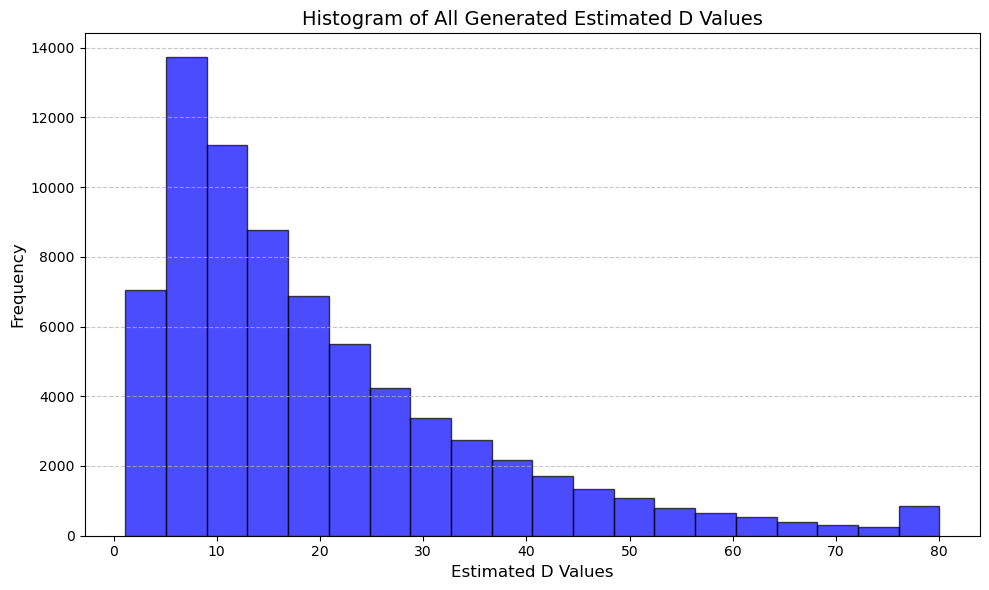

In [96]:

print(np.min(allGeneratedDs))
print(np.mean(allGeneratedDs))
print(np.max(allGeneratedDs))

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(np.clip(allGeneratedDs,0,80), bins=20, color='blue', edgecolor='black', alpha=0.7)

# Add labels, title, and grid
plt.xlabel('Estimated D Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of All Generated Estimated D Values', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()


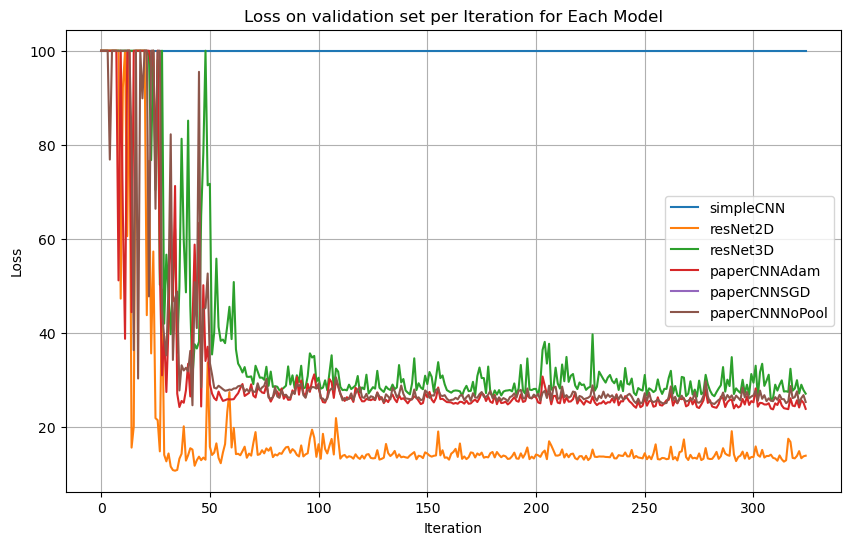

C:\Users\Emilien\AppData\Local\Temp\ipykernel_12268\3109743138.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valDs_tensor = torch.tensor(valDs, dtype=model_preds.dtype, device=model_preds.device)


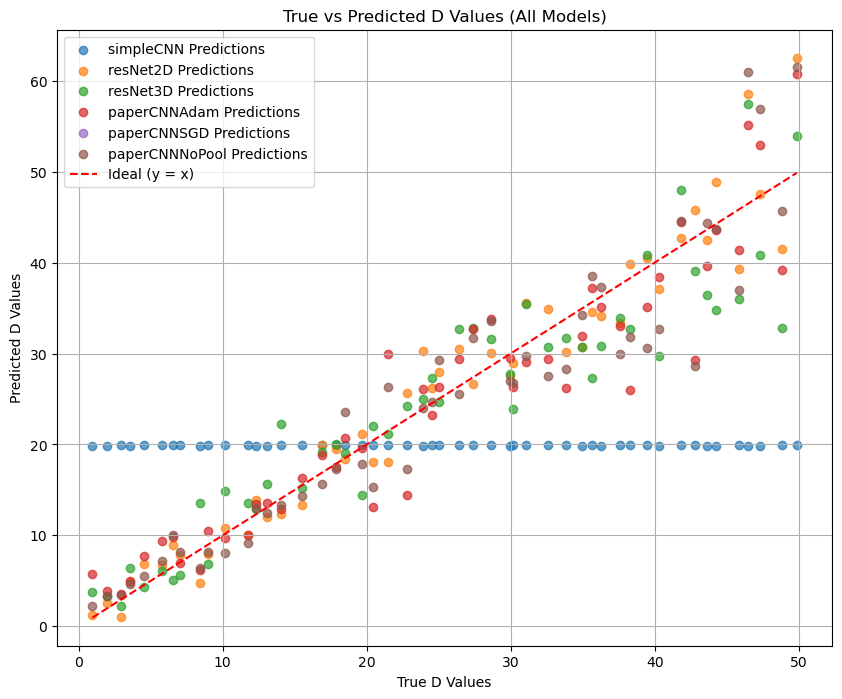

In [97]:
plt.figure(figsize=(10, 6))
for model_name, losses in val_loss_histories.items():
    plt.plot(range(0, totalEpochs ), np.clip(losses,0,100), label=model_name)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss on validation set per Iteration for Each Model')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))

# Iterate over all models to plot predictions vs true values
for name, params in models_params.items():
    # Predictions and true values
    model = params["loaded_model"]
    model_preds = predict_diffusion_coefficients(model, val_images, device)
    valDs_tensor = torch.tensor(valDs, dtype=model_preds.dtype, device=model_preds.device)
    
    # Ensure predictions and true values are on the same device and flattened
    model_preds = model_preds.view(-1).cpu().numpy()  # Convert to numpy for plotting
    valDs_array = valDs_tensor.view(-1).cpu().numpy()  # Convert to numpy for plotting

    # Scatter plot for the current model
    plt.scatter(valDs_array, model_preds, alpha=0.7, label=f'{name} Predictions')

# Plot the ideal line
min_val, max_val = min(valDs_array), max(valDs_array)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y = x)')

# Add plot details
plt.title("True vs Predicted D Values (All Models)")
plt.xlabel("True D Values")
plt.ylabel("Predicted D Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Iterate over all models to plot predictions vs true values
for name, params in models_params.items():
    # Predictions and true values
    model = params["loaded_model"]
    criterion = params["criterion"]
    model_preds = predict_diffusion_coefficients(model, val_images, device)
    model_predsRot = predict_with_rotations(model, val_images, device)
    valDs_tensor = torch.tensor(valDs, dtype=model_preds.dtype, device=model_preds.device)
    
    # Ensure predictions and true values are on the same device and flattened
    model_preds = model_preds.view(-1).cpu().numpy()  # Convert to numpy for plotting
    valDs_array = valDs_tensor.view(-1).cpu().numpy()  # Convert to numpy for plotting
    loss = criterion(model_preds, valDs)
    lossRot = criterion(model_predsRot, valDs)
    # Scatter plot for the current model
    print("Loss without rotation:", loss, "Loss with rotation", lossRot )
    plt.scatter(valDs_array, model_preds, alpha=0.7, label=f'{name} Predictions')

# Plot the ideal line
min_val, max_val = min(valDs_array), max(valDs_array)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y = x)')

# Add plot details
plt.title("True vs Predicted D Values (All Models)")
plt.xlabel("True D Values")
plt.ylabel("Predicted D Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

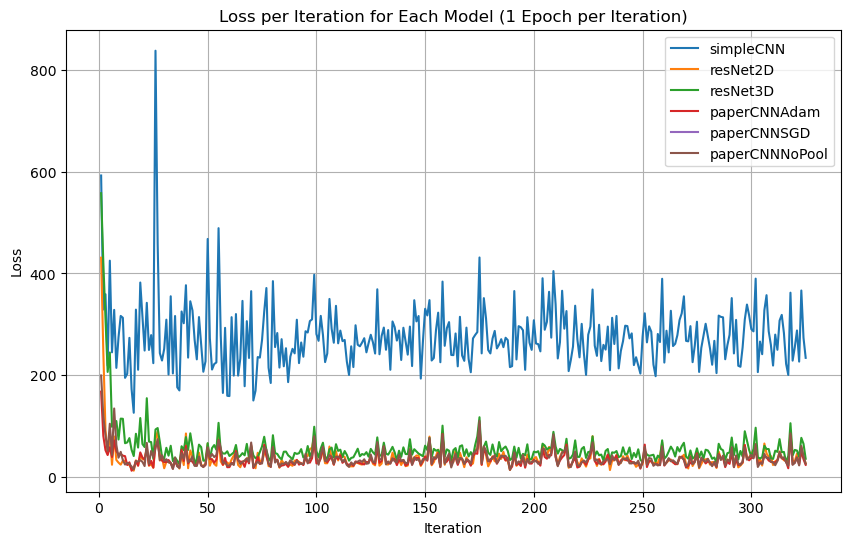

In [98]:

plt.figure(figsize=(10, 6))
for model_name, losses in tr_loss_histories.items():
    plt.plot(range(1, totalEpochs + 1), losses, label=model_name)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss per Iteration for Each Model (1 Epoch per Iteration)')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
# saves all used models 

for name, params in models_params.items():
    model = params["loaded_model"]
    filename = "w_"+name+".pth"
    save_model_weights(model,filename)

Model weights saved to w_simpleCNN.pth
Model weights saved to w_resNet2D.pth
Model weights saved to w_resNet3D.pth
Model weights saved to w_paperCNNAdam.pth
Model weights saved to w_paperCNNSGD.pth
Model weights saved to w_paperCNNNoPool.pth


In [100]:
# Save validation Loss and epochs
np.save("allDs.npy",allGeneratedDs)
for model_name, losses in val_loss_histories.items():
    filename = "l_"+model_name+".npy"
    np.save(filename,losses)

Image loaded from refImageSmall.npy
Real D value for image refImageSmall of model: simpleCNN : 1.9350. Model estimated value: 9.9311
Real D value for image refImageSmall of model: resNet : 1.9350. Model estimated value: 3.5535
Real D value for image refImageSmall of model: paperCNNAdam : 1.9350. Model estimated value: 1.8010
Real D value for image refImageSmall of model: paperCNNSGD : 1.9350. Model estimated value: 10.0318


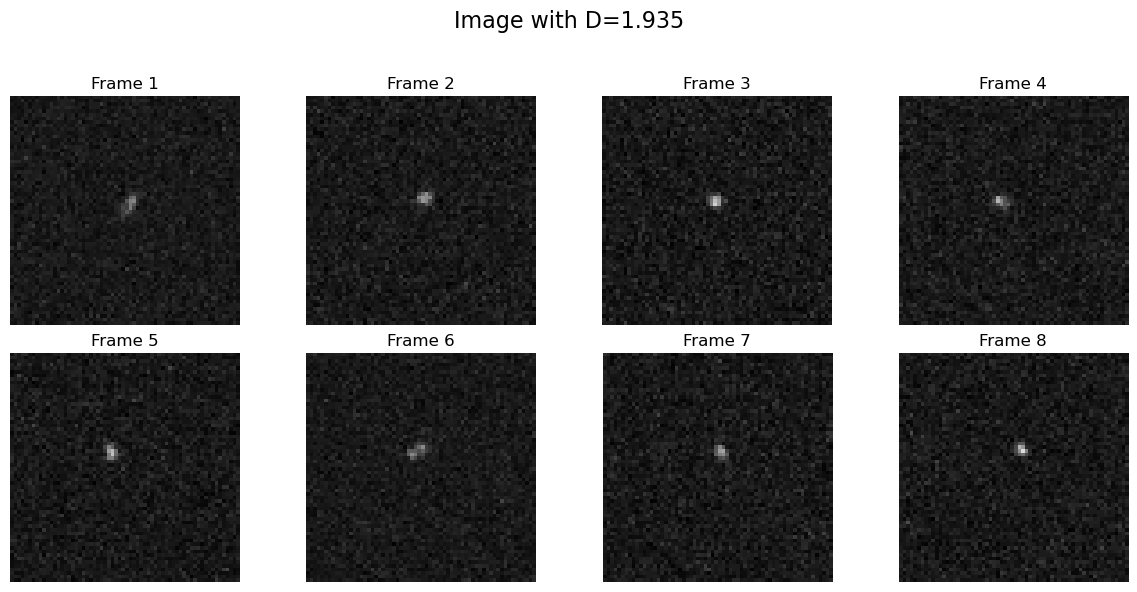

Image loaded from refImage.npy
Real D value for image refImage of model: simpleCNN : 13.8750. Model estimated value: 9.9311
Real D value for image refImage of model: resNet : 13.8750. Model estimated value: 9.6482
Real D value for image refImage of model: paperCNNAdam : 13.8750. Model estimated value: 14.2315
Real D value for image refImage of model: paperCNNSGD : 13.8750. Model estimated value: 10.0318


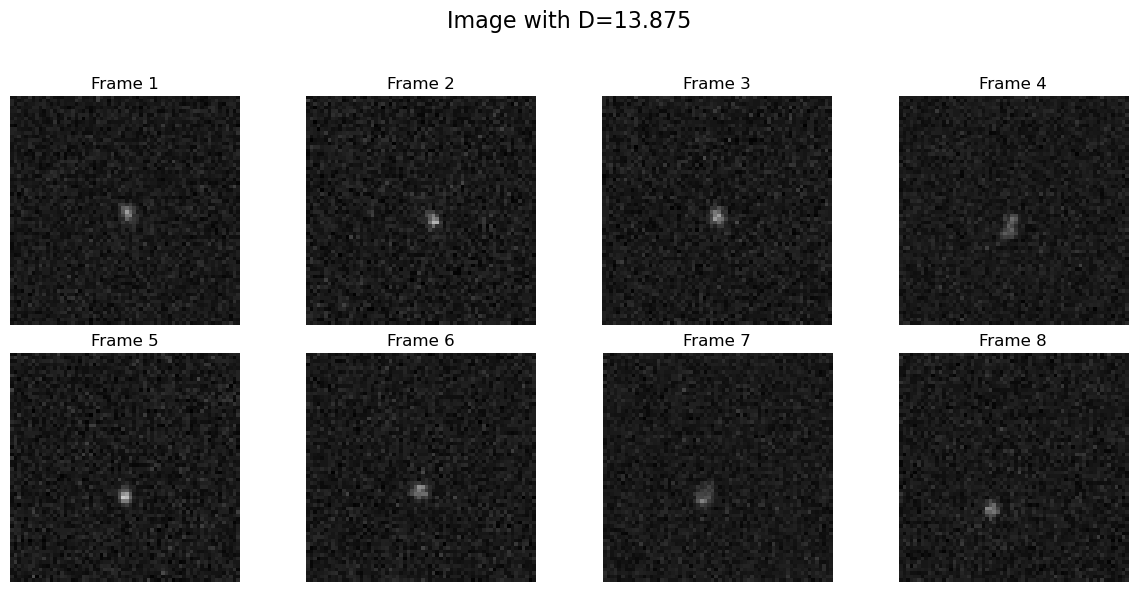

Image loaded from refImageBig.npy
Real D value for image refImageBig of model: simpleCNN : 26.0920. Model estimated value: 9.9311
Real D value for image refImageBig of model: resNet : 26.0920. Model estimated value: 35.0272
Real D value for image refImageBig of model: paperCNNAdam : 26.0920. Model estimated value: 22.5965
Real D value for image refImageBig of model: paperCNNSGD : 26.0920. Model estimated value: 10.0318


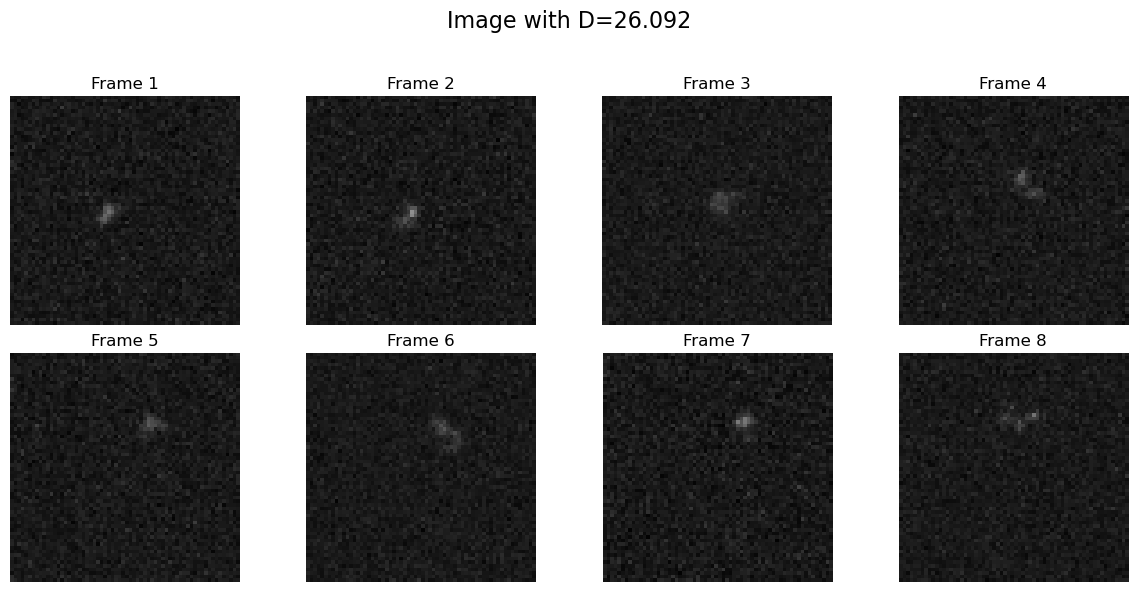

In [77]:
# Uncomment these 3 lines to generate a new reference image
#singleIm, singleestimatedDs = generateImagesAndEstimateD(1, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
#im, estD = singleIm[0,:], singleestimatedDs[0]
#save_image(im,"refImageBig.npy") 


# We created 3 reference images, with different D values, to observe what our algorithm predicts
dict = {"refImageSmall": 1.935, "refImage": 13.875, "refImageBig": 26.092}

for iname, estD in dict.items():
    im = load_image(iname + ".npy")
    for mname, params in models_params.items():
        model = params["loaded_model"]

        modelEstimation = predict_diffusion_coefficients(model, im ,device)
        print(f"Real D value for image {iname} of model: {mname} : {estD:.4f}. Model estimated value: {modelEstimation:.4f}")

    plot_image_frames(im,f"Image with D={estD}")


In [ ]:
# run this code to generate new 50 reference images that will be used to compute the validation loss at each iteration
"""
parts = 10000
trajectories = brownian_motion(parts,nframes,nposframe,DGen,dt,False)
time_range = np.arange(nframes * nposframe) * dt / nposframe

nIm = 50

trajsToSave = np.zeros((nIm,nframes*nposframe,2))
saved = np.zeros(nIm)
print(saved)

for p in range(parts):
    traj = trajectories[p,:]
    msd = mean_square_displacement(traj)
    estimD = estimateDfromMSD(msd,time_range)


    index = int(estimD/1000)
    if(index < nIm and saved[index] == 0 ):
        saved[index] = 1
        trajsToSave[index,:] = traj

print(saved)
np.save('validation_trajectories.npy',trajsToSave)"""

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
